In [1]:
import Pkg; 
Pkg.add(["Rocket", "Distributions"]);Pkg.activate(".."); Pkg.instantiate();
using RxInfer, Random, Plots, Rocket, Distributions, StableRNGs

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
┌ Warning: The active manifest file at `/ws/Manifest.toml` has an old format that is being maintained.
│ To update to the new format, which is supported by Julia versions ≥ 1.6.2, run `import Pkg; Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
│ To then record the julia version re-resolve with `Pkg.resolve()` and if there are resolve conflicts consider `Pkg.update()`.
└ @ Pkg.Types /usr/local/julia/share/julia/stdlib/v1.11/Pkg/src/manifest.jl:318
  No Changes to `/ws/Project.toml`
  No Changes to `/ws/Manifest.toml`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /ws/Manifest.toml:0
  Activating project at `/ws`


In [2]:
# Model
@model function beta_bernoulli_online(y, a, b)
  theta ~ Beta(a, b)
  y ~ Bernoulli(theta)
end

In [3]:
# Auto-updates
beta_bernoulli_autoupdates = @autoupdates begin
  a, b = params(q(theta))
end

@autoupdates begin
    (a, b) = params(q(theta))
end


#### Asynchronous Data Stream
Creating a handcrafted stream of observations with the `Rocket.jl` library

In [4]:
hidden_theta = 1/3.1415
distribution = Bernoulli(hidden_theta)
rng          = StableRNG(43)
datastream  = RecentSubject(Bool)

observations = labeled(Val((:y, )), combineLatest(datastream))

LabeledObservable(@NamedTuple{y::Bool}, Rocket.CombineLatestObservable{Tuple{Bool}, Tuple{Rocket.RecentSubjectInstance{Bool, Subject{Bool, AsapScheduler, AsapScheduler}}}, PushEach})

In [5]:
subscription = subscribe!(observations,
  (new_observation) -> println("Got new observation: ", new_observation)
) 

CombineLatestSubscription()

In [6]:
for i in 1:5
  next!(datastream, rand(rng, distribution))
end
#@test all(value -> haskey(value, :y) && (isone(value[:y]) || iszero(value[:y])), test_values) #hide

Got new observation: (y = false,)
Got new observation: (y = true,)
Got new observation: (y = false,)
Got new observation: (y = true,)
Got new observation: (y = false,)


In [7]:
# It is important to keep track of the existing susbcriptions
# and unsubscribe to reduce the usage of computational resources
unsubscribe!(subscription)

In [8]:
engine = infer(
  model          = beta_bernoulli_online(),
  datastream     = observations,
  autoupdates    = beta_bernoulli_autoupdates,
  returnvars     = (:theta, ),
  initialization = @initialization(q(theta) = Beta(1, 1)),
  autostart      = false
)

RxInferenceEngine:
  Posteriors stream    | enabled for (theta)
  Free Energy stream   | disabled
  Posteriors history   | unavailable
  Free Energy history  | unavailable
  Enabled events       | [  ]

In [9]:
theta_updates_subscription = subscribe!(engine.posteriors[:theta],
    (new_posterior_for_theta) -> println("A new posterior for θ is ", new_posterior_for_theta, " 🤩")
)

Rocket.PendingSchedulerSubscription(Rocket.LazySubscription(RefCountSubscription()), PendingScheduler(), Rocket.PendingActor{Marginal, Rocket.MapActor{Marginal, FunctionActor{Any, var"#19#20"}, RxInfer.var"#227#243"{DefaultPostprocess}}}(MapActor(Marginal), nothing))

In [10]:
RxInfer.start(engine)

A new posterior for θ is Beta{Float64}(α=1.0, β=2.0) 🤩


In [11]:
for i in 1:5
    next!(datastream, rand(rng, distribution))
end

A new posterior for θ is Beta{Float64}(α=1.0, β=3.0) 🤩
A new posterior for θ is Beta{Float64}(α=1.0, β=4.0) 🤩
A new posterior for θ is Beta{Float64}(α=2.0, β=4.0) 🤩
A new posterior for θ is Beta{Float64}(α=2.0, β=5.0) 🤩
A new posterior for θ is Beta{Float64}(α=2.0, β=6.0) 🤩


In [18]:
RxInfer.stop(engine)
unsubscribe!(theta_updates_subscription)

In [19]:
engine = infer(
  model          = beta_bernoulli_online(),
  datastream     = observations,
  autoupdates    = beta_bernoulli_autoupdates,
  initialization = @initialization(q(theta) = Beta(1, 1)),
  keephistory    = 100,
  historyvars    = (theta = KeepLast(), ),
  autostart      = true
)

RxInferenceEngine:
  Posteriors stream    | enabled for (theta)
  Free Energy stream   | disabled
  Posteriors history   | available for (theta)
  Free Energy history  | unavailable
  Enabled events       | [  ]

In [20]:
for i in 1:200
    next!(datastream, rand(rng, distribution))
end

┌ Info: Saved animation to /tmp/jl_K10XC7m3Y3.gif
└ @ Plots /root/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_K10XC7m3Y3.gif")
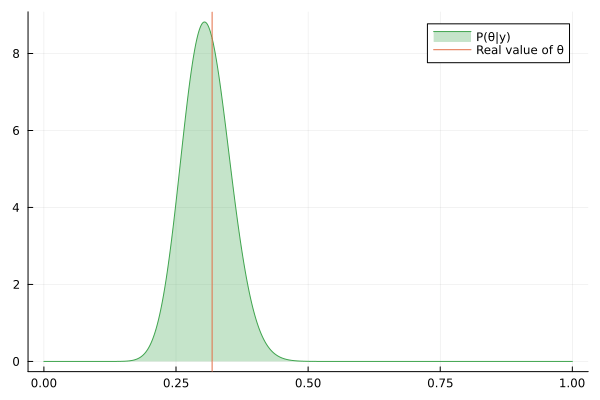

In [21]:
using Plots

@gif for posterior in engine.history[:theta]
    rθ = range(0, 1, length = 1000)
    pθ = plot(rθ, (x) -> pdf(posterior, x), fillalpha=0.3, fillrange = 0, label="P(θ|y)", c=3)
    pθ = vline!(pθ, [ hidden_theta ], label = "Real value of θ")

    plot(pθ)
end